## 1. Подключение библиотек и создание SparkSession

In [1]:
import os
from pyspark import SparkConf
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import *
from pyspark.sql.functions import (
    col, lit, when, expr, trim, upper, lower,
    to_timestamp, regexp_replace, regexp_extract,
    year, month, dayofweek, hour, round as s_round,
    count, countDistinct, avg, stddev, approx_count_distinct
)

In [3]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            11Gi       969Mi        10Gi       1.0Mi       594Mi        10Gi
Swap:          8.0Gi        72Mi       7.9Gi


In [2]:
conf = (
    SparkConf()
    .setAppName("SOBD_Lab1_Local_Taxi")
    .setMaster("local[*]")                    # все ядра
    .set("spark.driver.memory", "10g")        # максимум RAM, сколько есть в системе (8–12 гб)
    .set("spark.executor.memory", "10g")      # память воркеров
    .set("spark.sql.shuffle.partitions", "100")  # меньше партиций = меньше накладных расходов
    .set("spark.default.parallelism", "100")  # совпадает с количеством партиций
    .set("spark.sql.execution.arrow.pyspark.enabled", "true")  # ускорение Pandas-конверсий
    .set("spark.sql.execution.arrow.maxRecordsPerBatch", "500000")
    .set("spark.sql.broadcastTimeout", "36000")  # не отваливаться при больших join’ах
    .set("spark.local.dir", "/tmp/spark-temp")   # директория для временных shuffle-файлов
    .set("spark.memory.fraction", "0.8")         # выделить максимум под вычисления
    .set("spark.ui.showConsoleProgress", "true")
)

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

## 2. Путь к данным и чтение CSV

In [3]:
path = "/home/jovyan/work/data/2018_Yellow_Taxi_Trip_Data.csv"

df_raw = (
    spark.read.csv(
        path,
        header=True,
        inferSchema=True,
        multiLine=False,
        mode="PERMISSIVE"
    )
)

df_raw.printSchema()
df_raw.show(5, truncate=False)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)

+--------+----------------------+----------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+--------------------

In [5]:
df_raw.limit(5).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,07/17/2018 10:14:57 AM,07/17/2018 10:22:45 AM,2,1,1,N,186,234,1,7,0.0,0.5,2.34,0,0.3,10.14
1,2,07/17/2018 10:23:50 AM,07/17/2018 10:37:49 AM,2,1.24,1,N,234,186,1,9.5,0.0,0.5,1.03,0,0.3,11.33
2,2,07/17/2018 10:39:57 AM,07/17/2018 11:07:52 AM,2,5.12,1,N,186,88,1,22,0.0,0.5,2.00,0,0.3,24.8
3,2,07/17/2018 10:12:58 AM,07/17/2018 10:22:47 AM,1,0.88,1,N,48,186,2,7.5,0.0,0.5,0.00,0,0.3,8.3
4,2,07/17/2018 10:24:49 AM,07/17/2018 10:48:37 AM,1,2.07,1,N,186,163,1,15,0.0,0.5,0.79,0,0.3,16.59


## 3. Привести имена к snake_case и зафиксировать типы

In [5]:
# helper: упрощаем названия столбцов
def to_snake(s: str) -> str:
    return (
        s.strip()
         .replace(" ", "_")
         .replace("-", "_")
         .replace(".", "_")
         .lower()
    )

df = df_raw.toDF(*[to_snake(c) for c in df_raw.columns])

# привести типы (где нужно) и распарсить даты
# если каких-то столбцов в твоём csv нет — просто убери их из списка.
casts = {
    "passenger_count": "int",
    "trip_distance": "double",
    "ratecodeid": "int",
    "pulocationid": "int",
    "dolocationid": "int",
    "payment_type": "int",
    "fare_amount": "double",
    "extra": "double",
    "mta_tax": "double",
    "tip_amount": "double",
    "tolls_amount": "double",
    "improvement_surcharge": "double",
    "total_amount": "double",
    "congestion_surcharge": "double",
}

for c, t in casts.items():
    if c in df.columns:
        df = df.withColumn(c, col(c).cast(t))

# даты-время
for tcol in ["tpep_pickup_datetime", "tpep_dropoff_datetime"]:
    if tcol in df.columns and dict(df.dtypes)[tcol] != "timestamp":
        df = df.withColumn(tcol, to_timestamp(col(tcol)))

df.printSchema()

root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



## 4. Проверка качества: пропуски/дубликаты

In [6]:
# Проверяем только существование null (isNull), без isnan
missing_df = (
    df.select([
        count(when(col(c).isNull(), c)).alias(c)
        for c in df.columns
    ])
)

missing_df.limit(5).toPandas()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,0,112234626,112234626,0,19,0,0,0,0,0,164,0,0,0,2,3,175


# добавть просмотр дубликатов

In [10]:
from pyspark.sql import functions as F


dup_rows = (
    df.groupBy(df.columns)
      .agg(F.count("*").alias("cnt"))
      .filter("cnt > 1")
)

dup_rows.limit(30).toPandas()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,cnt
0,2,NaT,NaT,2,1.55,1,N,140,162,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30,5
1,2,NaT,NaT,1,0.94,1,N,186,161,1,8.5,0.0,0.5,2.32,0.0,0.3,11.62,2
2,1,NaT,NaT,1,0.90,1,N,231,87,1,8.5,0.0,0.5,1.86,0.0,0.3,11.16,3
3,1,NaT,NaT,1,0.20,1,N,100,100,1,3.5,0.0,0.5,0.00,0.0,0.3,4.30,6
4,2,NaT,NaT,1,0.54,1,N,43,43,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16,4
5,2,NaT,NaT,1,0.66,1,N,186,48,2,6.5,0.0,0.5,0.00,0.0,0.3,7.30,20
6,1,NaT,NaT,1,0.70,1,N,162,229,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30,12
7,2,NaT,NaT,1,1.50,1,N,186,125,1,10.0,0.0,0.5,2.16,0.0,0.3,12.96,2
8,1,NaT,NaT,1,2.00,1,N,48,234,1,12.0,0.0,0.5,1.00,0.0,0.3,13.80,2
9,2,NaT,NaT,1,0.52,1,N,234,170,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16,4


In [7]:
duplicates_count = df.count() - df.dropDuplicates().count()
print(f"Количество дубликатов: {duplicates_count}")

Количество дубликатов: 53283663


In [8]:
# Общая статистика 
df.describe(
    "trip_distance", "fare_amount", "tip_amount", "total_amount"
).show()

+-------+------------------+------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|        tip_amount|      total_amount|
+-------+------------------+------------------+------------------+------------------+
|  count|         112234607|         112234462|         112234626|         112234451|
|   mean|2.9272869949996516|12.973791676838115|1.8724737629549453|16.322630659711695|
| stddev| 3.794792073465626|11.608532977517953|2.6079470523617867|14.351499573938945|
|    min|               0.0|            -800.0|           -322.42|            -800.3|
|    max|             943.5|            999.99|            945.97|            999.56|
+-------+------------------+------------------+------------------+------------------+



In [9]:
from pyspark.sql.functions import col, to_timestamp, trim

# 1. стартуем снова от сырого df_raw и делаем snake_case
df = df_raw.toDF(*[c.strip().replace(" ","_").replace("-","_").replace(".","_").lower()
                   for c in df_raw.columns])

# 2. ПРАВИЛЬНЫЙ формат для дат 
fmt = "M/d/yyyy h:mm:ss a"   # напр.: 07/17/2018 10:14:57 AM

df = (
    df.withColumn("tpep_pickup_datetime",
                  to_timestamp(trim(col("tpep_pickup_datetime")), fmt))
      .withColumn("tpep_dropoff_datetime",
                  to_timestamp(trim(col("tpep_dropoff_datetime")), fmt))
)

# проверка
df.select("tpep_pickup_datetime","tpep_dropoff_datetime").show(5, truncate=False)


+--------------------+---------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|
+--------------------+---------------------+
|2018-07-17 10:14:57 |2018-07-17 10:22:45  |
|2018-07-17 10:23:50 |2018-07-17 10:37:49  |
|2018-07-17 10:39:57 |2018-07-17 11:07:52  |
|2018-07-17 10:12:58 |2018-07-17 10:22:47  |
|2018-07-17 10:24:49 |2018-07-17 10:48:37  |
+--------------------+---------------------+
only showing top 5 rows



In [10]:
# Временной диапазон поездок 
from pyspark.sql.functions import min, max


df.select(
    min("tpep_pickup_datetime").alias("min_pickup"),
    max("tpep_dropoff_datetime").alias("max_dropoff")
).show()

+-------------------+-------------------+
|         min_pickup|        max_dropoff|
+-------------------+-------------------+
|2001-01-01 00:01:48|2084-11-04 12:47:41|
+-------------------+-------------------+



In [10]:
from pyspark.sql.functions import col, when


# Добавляем длительность и скорость
df = (
    df.withColumn("trip_minutes", 
        (col("tpep_dropoff_datetime").cast("long") - col("tpep_pickup_datetime").cast("long")) / 60.0
    )
    .withColumn("trip_hours", col("trip_minutes") / 60.0)
    .withColumn("speed_mph", when(col("trip_hours") > 0, col("trip_distance") / col("trip_hours")))
)

df.select("trip_distance", "trip_minutes", "trip_hours", "speed_mph").show(5)


+-------------+------------------+-------------------+------------------+
|trip_distance|      trip_minutes|         trip_hours|         speed_mph|
+-------------+------------------+-------------------+------------------+
|          1.0|               7.8|               0.13| 7.692307692307692|
|         1.24|13.983333333333333|0.23305555555555554|  5.32061978545888|
|         5.12|27.916666666666668| 0.4652777777777778|11.004179104477611|
|         0.88| 9.816666666666666| 0.1636111111111111| 5.378607809847199|
|         2.07|              23.8|0.39666666666666667| 5.218487394957982|
+-------------+------------------+-------------------+------------------+
only showing top 5 rows



## 5.Выбросы

In [11]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
import builtins

# Приводим столбец к числовому типу
df_num = df.withColumn("trip_distance", F.col("trip_distance").cast(DoubleType()))

# Убираем только null в trip_distance
df_num = df_num.na.drop(subset=["trip_distance"])

# Квантили
q1, median, q3 = df_num.approxQuantile("trip_distance", [0.25, 0.5, 0.75], 0.01)
iqr = q3 - q1

# теоретические границы выбросов
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# реальные мин/макс
min_v, max_v = df_num.select(
    F.min("trip_distance"),
    F.max("trip_distance")
).first()

# безопасные усы
lower_bound = builtins.max(lower_bound, min_v)
upper_bound = builtins.min(upper_bound, max_v)

# подсчёт выбросов
total_cnt = df_num.count()
outliers_cnt = df_num.filter(
    (F.col("trip_distance") < lower_bound) |
    (F.col("trip_distance") > upper_bound)
).count()

# вывод
print(f"Всего записей: {total_cnt}")
print(f"Q1 = {q1:.2f}, Median = {median:.2f}, Q3 = {q3:.2f}, IQR = {iqr:.2f}")
print(f"Усы: [{lower_bound:.2f}; {upper_bound:.2f}]")
print(f"Потенциальных выбросов: {outliers_cnt} ({outliers_cnt / total_cnt * 100:.2f} %)")

Всего записей: 112234607
Q1 = 0.96, Median = 1.60, Q3 = 3.00, IQR = 2.04
Усы: [0.00; 6.06]
Потенциальных выбросов: 12792209 (11.40 %)


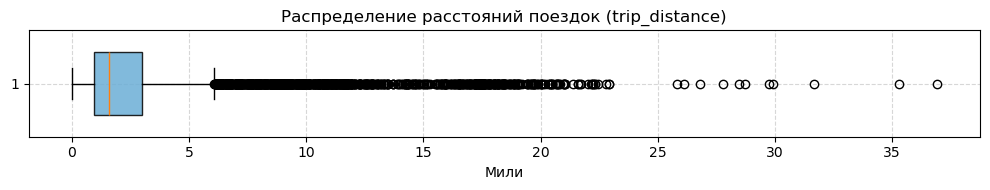

In [13]:
import matplotlib.pyplot as plt


# Выборка выбросов (не тащим миллионы строк)
outliers_df = df_num.filter(
    (F.col("trip_distance") < lower_bound) |
    (F.col("trip_distance") > upper_bound)
)

outliers = [
    r[0] for r in (
        outliers_df
        .select("trip_distance")
        .sample(False, 0.02, seed=42)
        .limit(1000)
        .collect()
    )
]

# структура boxplot
box_data = [{
    "whislo":  lower_bound,
    "q1":      q1,
    "med":     median,
    "q3":      q3,
    "whishi":  upper_bound,
    "fliers":  outliers
}]

# рисуем boxplot
fig, ax = plt.subplots(figsize=(10, 2))
bp = ax.bxp(box_data, vert=False, widths=0.6, patch_artist=True)

# цвет
for box in bp['boxes']:
    box.set_facecolor("#6BAED6")
    box.set_alpha(0.85)

ax.set_title("Распределение расстояний поездок (trip_distance)")
ax.set_xlabel("Мили")
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

## Фильтрация выбросов

In [14]:
# Приводим столбцы к double
df_num = (
    df.withColumn("trip_distance", col("trip_distance").cast(DoubleType()))
      .withColumn("fare_amount", col("fare_amount").cast(DoubleType()))
      .withColumn("total_amount", col("total_amount").cast(DoubleType()))
)

# ---- Вычисляем границы выбросов trip_distance ----
q1, median, q3 = df_num.approxQuantile("trip_distance", [0.25, 0.5, 0.75], 0.01)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# реальные min/max
min_v, max_v = df_num.select(
    F.min("trip_distance"), F.max("trip_distance")
).first()

# безопасные границы
lower_bound = builtins.max(lower_bound, min_v)
upper_bound = builtins.min(upper_bound, max_v)

# ---- Очистка ----
df_clean = (
    df_num
    .filter((col("trip_distance") >= lower_bound) & (col("trip_distance") <= upper_bound))
    .filter((col("fare_amount") > 0) & (col("fare_amount") < 500))
    .filter((col("total_amount") > 0) & (col("total_amount") < 500))
)

before = df_num.count()
after = df_clean.count()

print("Очистка завершена")
print(f"Строк до очистки: {before}")
print(f"Строк после очистки: {after}")
print(f"Удалено: {before - after} ({(before - after)/before*100:.2f}%)")

df_clean.select("trip_distance", "fare_amount", "total_amount").show(10, truncate=False)

Очистка завершена
Строк до очистки: 112234626
Строк после очистки: 99343130
Удалено: 12891496 (11.49%)
+-------------+-----------+------------+
|trip_distance|fare_amount|total_amount|
+-------------+-----------+------------+
|1.0          |7.0        |10.14       |
|1.24         |9.5        |11.33       |
|5.12         |22.0       |24.8        |
|0.88         |7.5        |8.3         |
|2.07         |15.0       |16.59       |
|1.2          |8.5        |11.15       |
|1.3          |10.0       |10.8        |
|4.03         |20.5       |25.56       |
|2.31         |16.5       |19.3        |
|0.63         |5.0        |6.96        |
+-------------+-----------+------------+
only showing top 10 rows



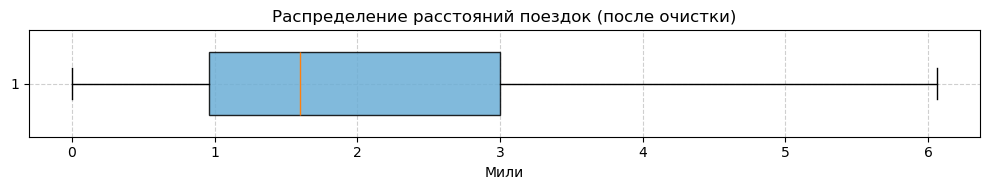

In [15]:
# Получаем выбросы
outliers_df = df_clean.filter(
    (F.col("trip_distance") < lower_bound) |
    (F.col("trip_distance") > upper_bound)
)

# Сэмплируем только выбросы (чтобы не собирать миллионы строк)
outliers = [
    r[0] for r in (
        outliers_df
        .select("trip_distance")
        .sample(False, 0.02, seed=42)
        .limit(1000)
        .collect()
    )
]

# Формируем данные для matplotlib.bxp()
box_data = [{
    "whislo":  lower_bound,
    "q1":      q1,
    "med":     median,
    "q3":      q3,
    "whishi":  upper_bound,
    "fliers":  outliers
}]

# Рисуем
fig, ax = plt.subplots(figsize=(10, 2))
bp = ax.bxp(box_data, vert=False, widths=0.6, patch_artist=True)

# Цвет
for box in bp['boxes']:
    box.set_facecolor("#6BAED6")
    box.set_alpha(0.85)

ax.set_title("Распределение расстояний поездок (после очистки)")
ax.set_xlabel("Мили")
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

## 6.Сохранение очищенных данных

In [15]:
output_path = "/home/jovyan/work/data/clean_taxi_data2.parquet"

df_clean.write.mode("overwrite").parquet(output_path)
print(f"Данные успешно сохранены в {output_path}")

Данные успешно сохранены в /home/jovyan/work/data/clean_taxi_data2.parquet


In [16]:
df_check = spark.read.parquet(output_path)
print("Количество строк:", df_check.count())
df_check.show(5)

Количество строк: 99343130
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2018-01-01 02:49:29|  2018-01-01 03:07:24|              1|         4.78|         1|                 N|          79|         163|           1|       18.0|  0.5|    0.5|      3.86|           0|                  0.3|       23.16|
|       2| 2018-01-01